In [ ]:
!pip install segmentation-models-pytorch -q
!pip install pytorch-lightning -q
!pip install wldhx.yadisk-direct -q
!pip install torchtext -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 13.5 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

from pprint import pprint
from torch.utils.data import Dataset, DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from PIL import Image
from torchvision import transforms


class AdversarialDataset(Dataset):
    def __init__(self, data_dir, labels_dir=''):

        self.XImg_list = []

        self.label_path = os.path.join(os.getcwd(), labels_dir)
        self.rgb_path = os.path.join(os.getcwd(), data_dir)
        self.XImg_list = sorted(os.listdir(self.rgb_path))
        
    def __len__(self):
        length = len(self.XImg_list)
        return length

    def __getitem__(self, index):
        image = Image.open(f'{self.rgb_path}/{self.XImg_list[index]}')

        image = transforms.ToTensor()(image)
        image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)
        return image


In [ ]:
dataset = AdversarialDataset('/content/drive/')

torch.Size([3, 64, 64])


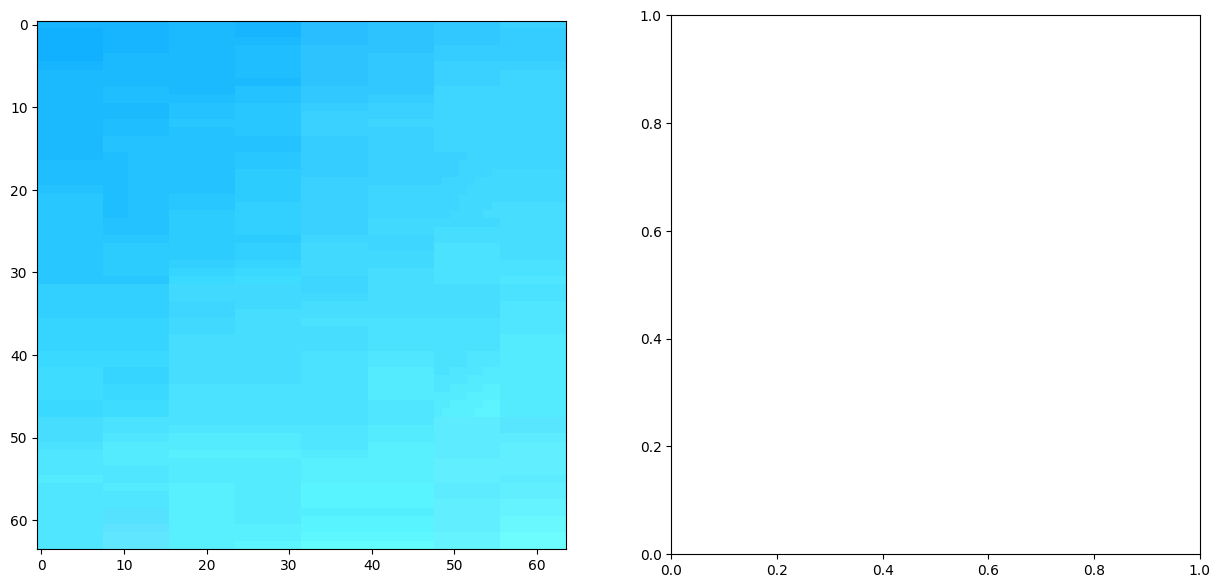

In [ ]:
img = dataset[3]
print(img.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
class AdversarialModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)


    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch[0]
        assert image.ndim == 4

  
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch[1]
        assert mask.ndim == 4

        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        loss = self.loss_fn(logits_mask, mask)
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")          

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [ ]:
model = AdversarialModel("FPN", "resnet34", in_channels=3, out_classes=1)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 86.0MB/s]


In [ ]:
model.load_state_dict(torch.load('/content/drive/'))

<All keys matched successfully>

In [ ]:
image = dataset[54]

In [ ]:
val_loader = torch.utils.data.DataLoader(image, batch_size=16, shuffle=False)

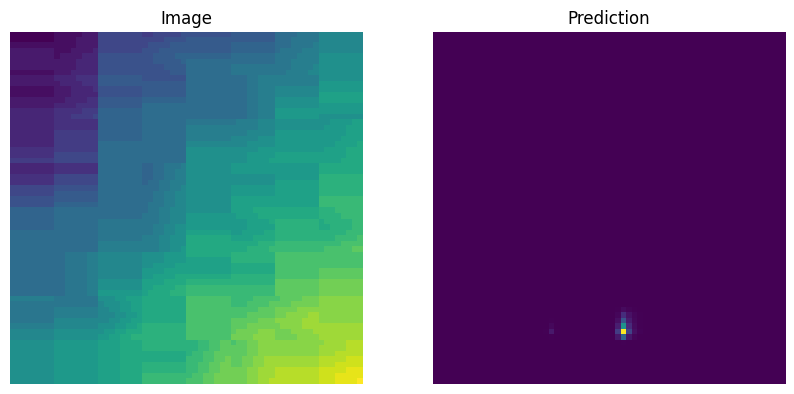

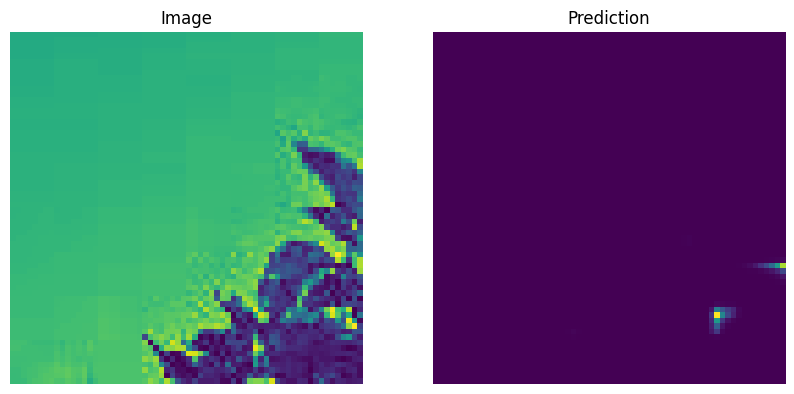

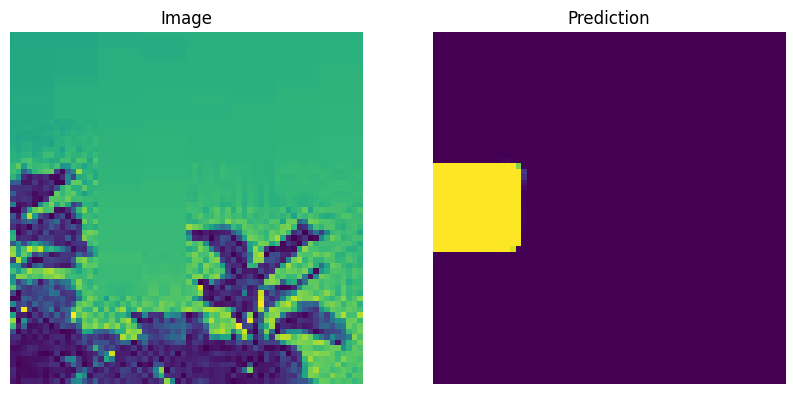

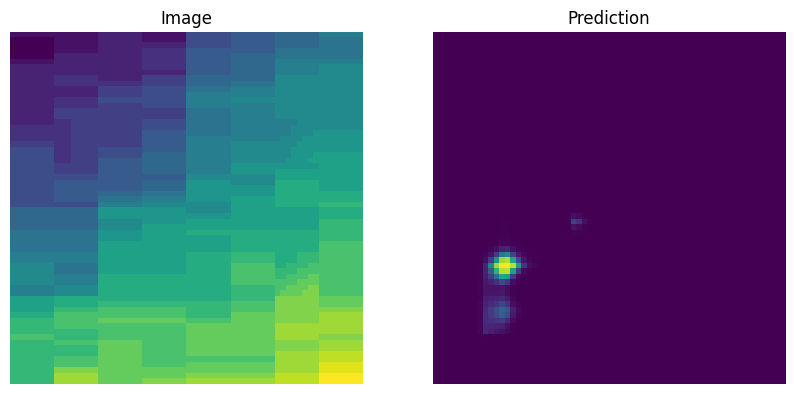

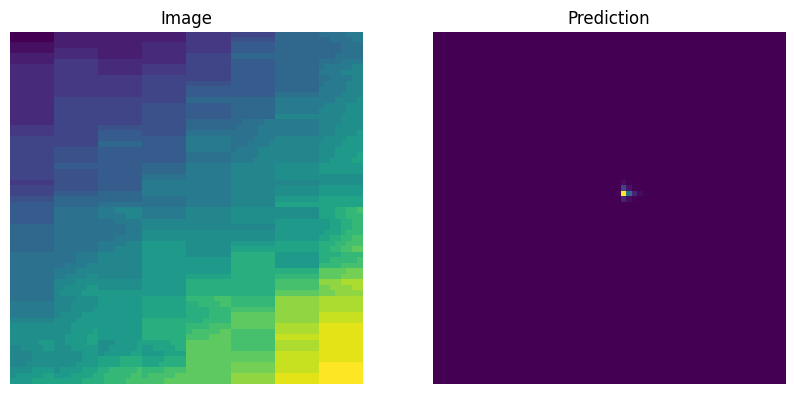

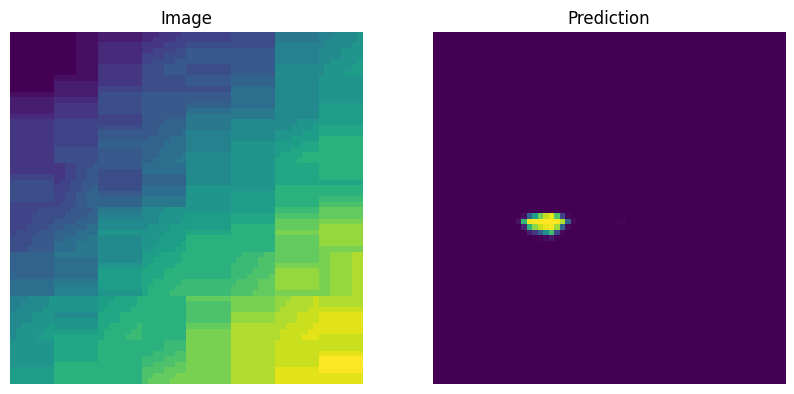

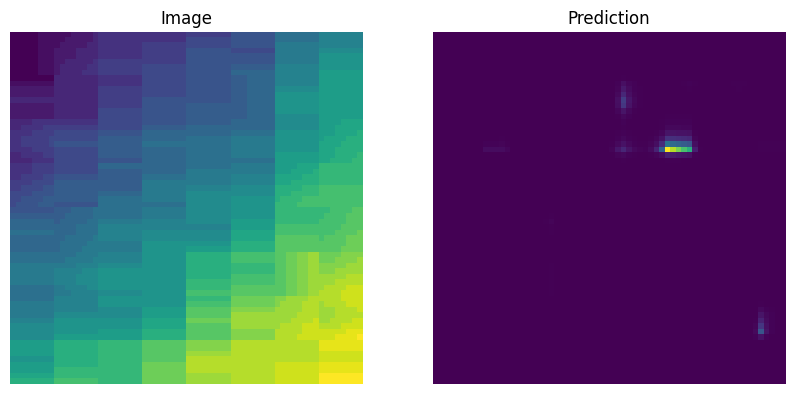

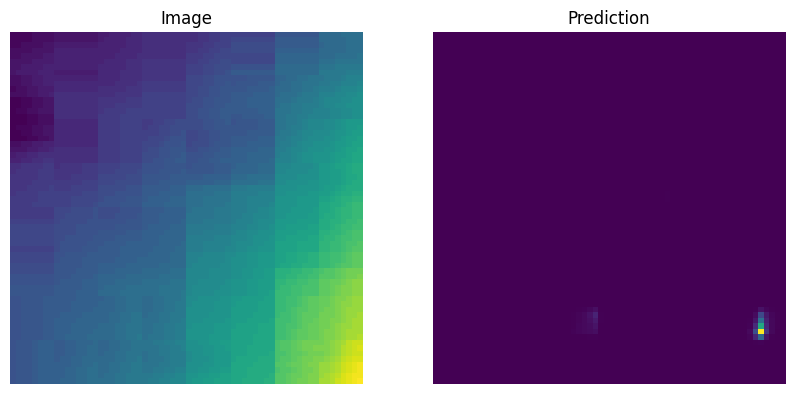

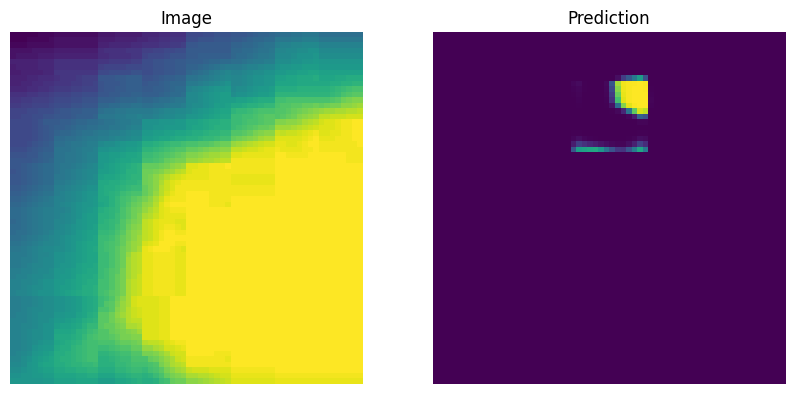

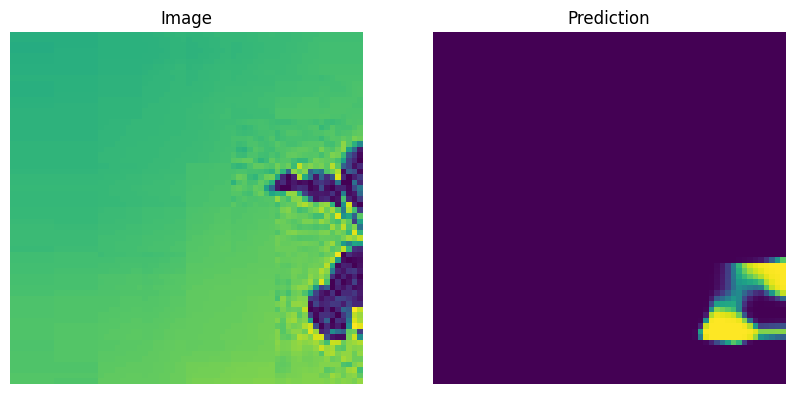

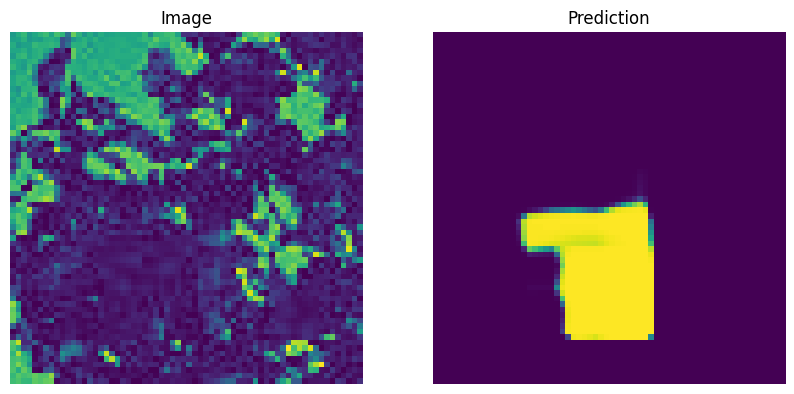

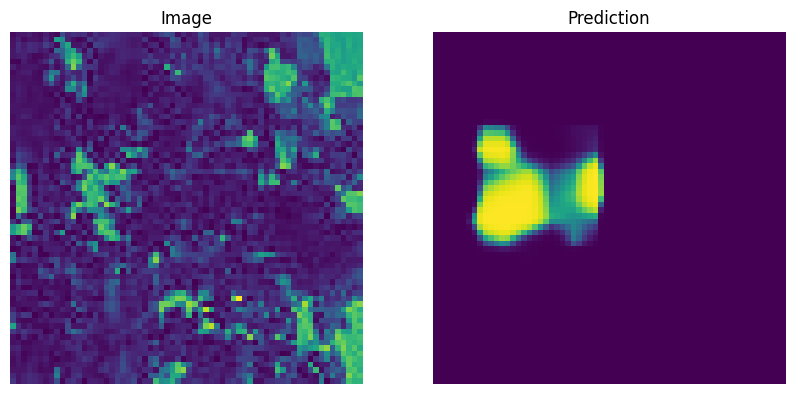

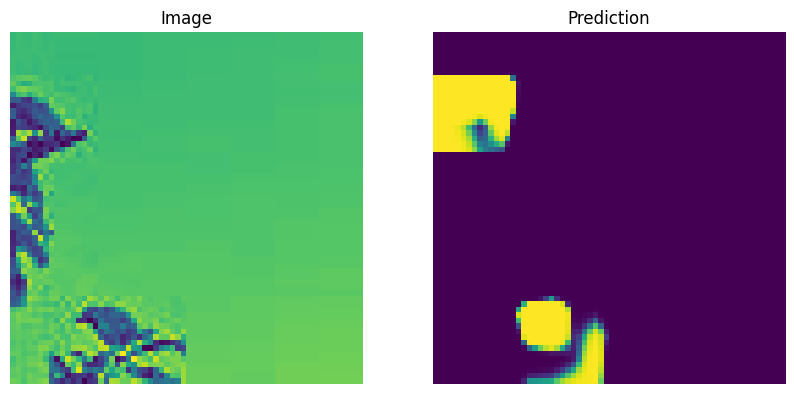

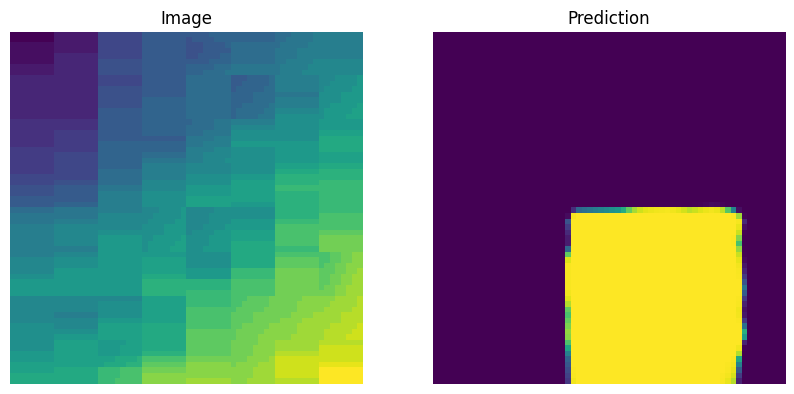

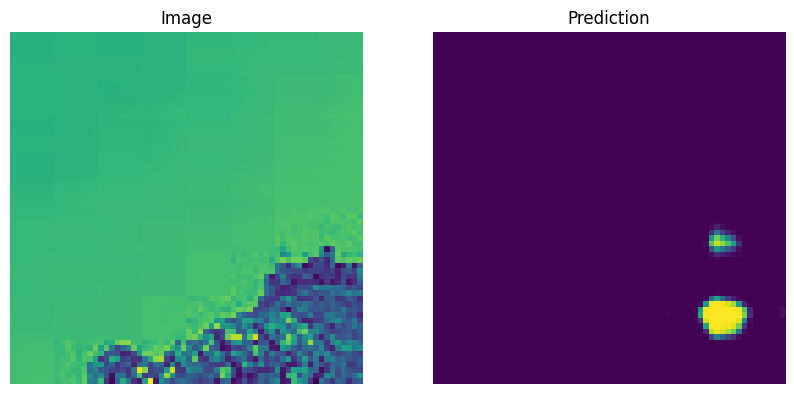

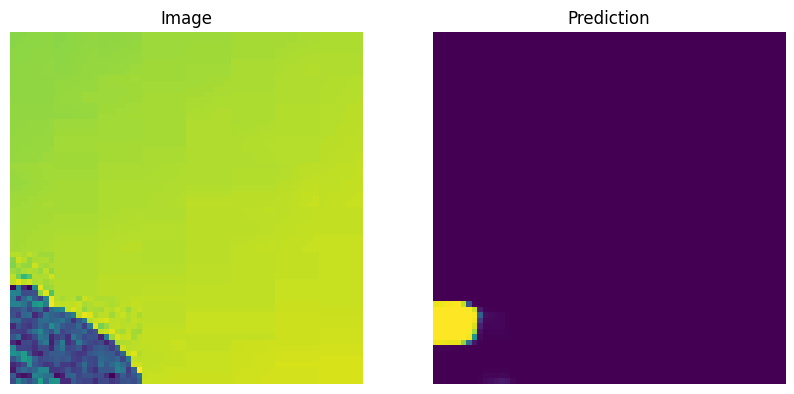

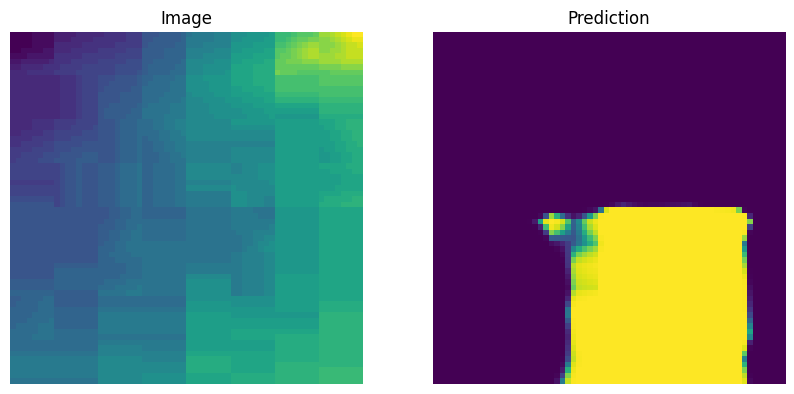

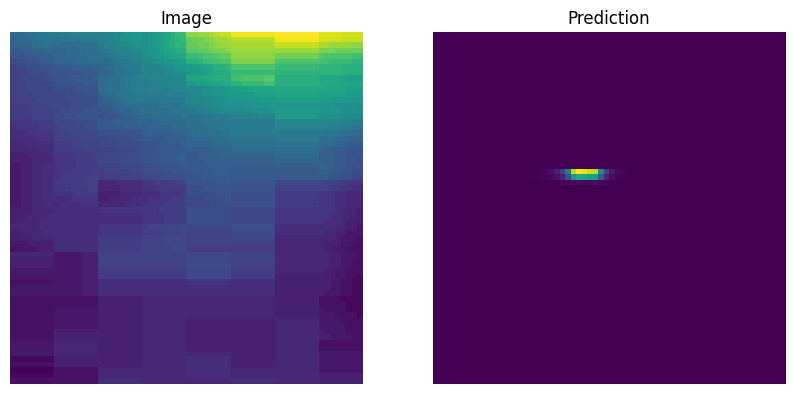

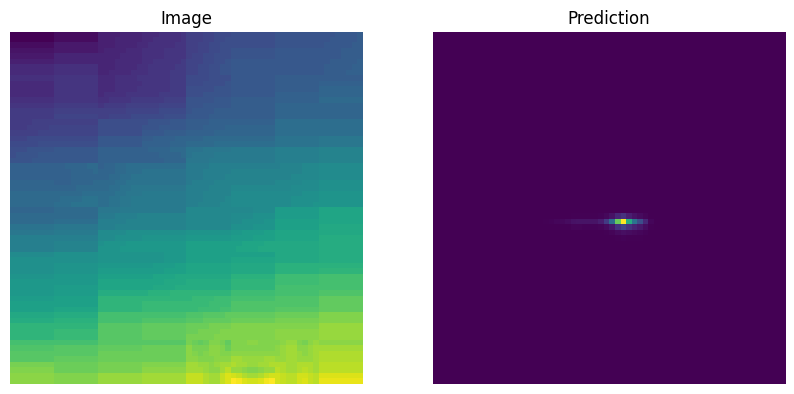

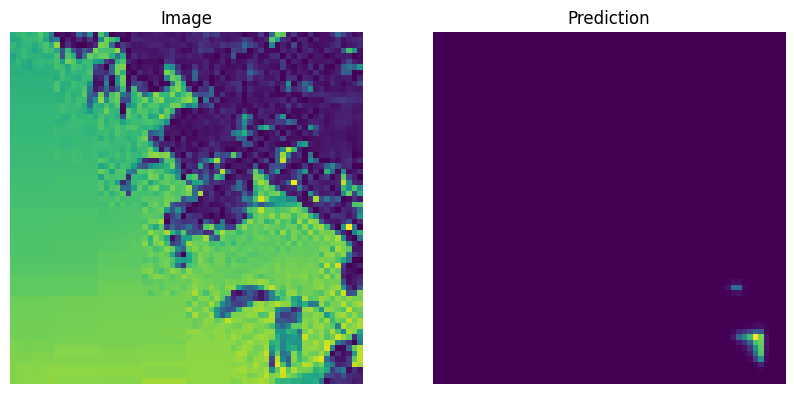

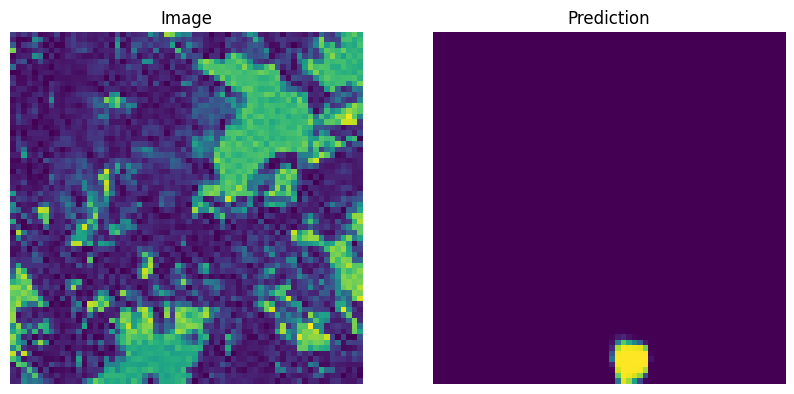

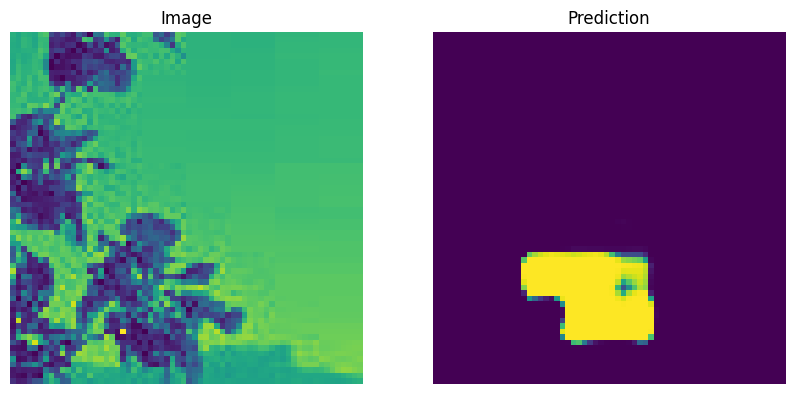

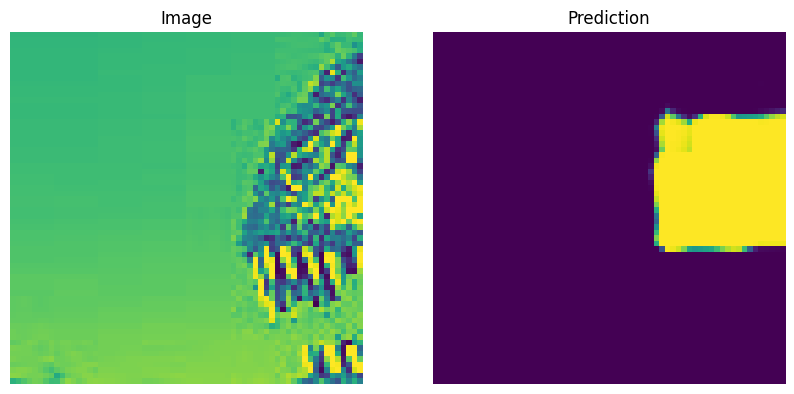

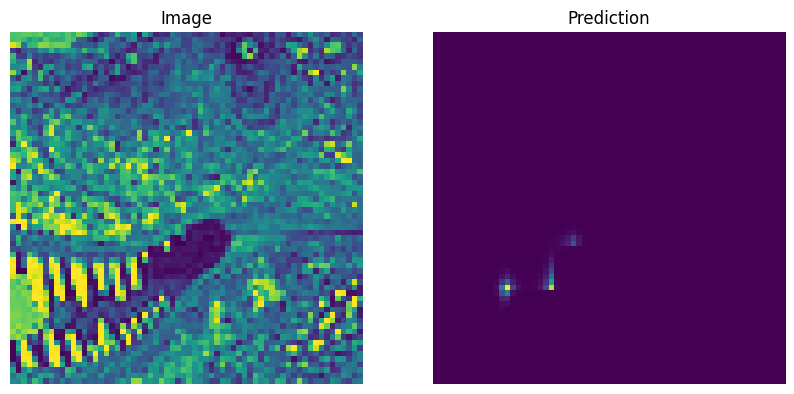

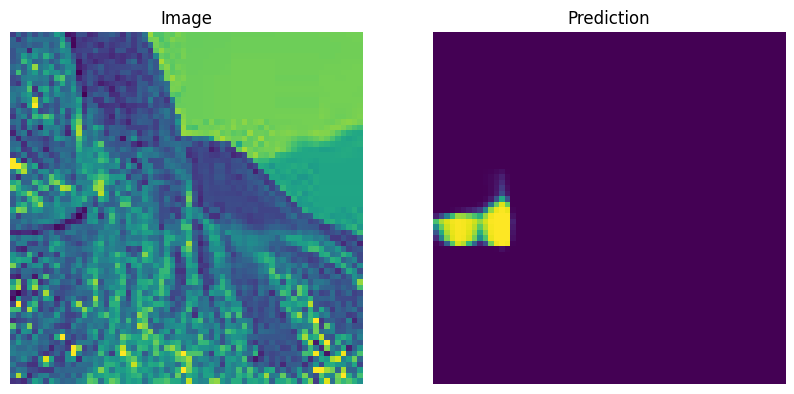

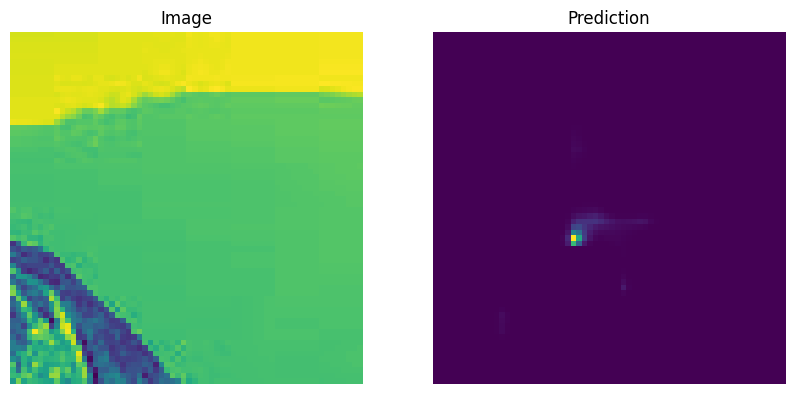

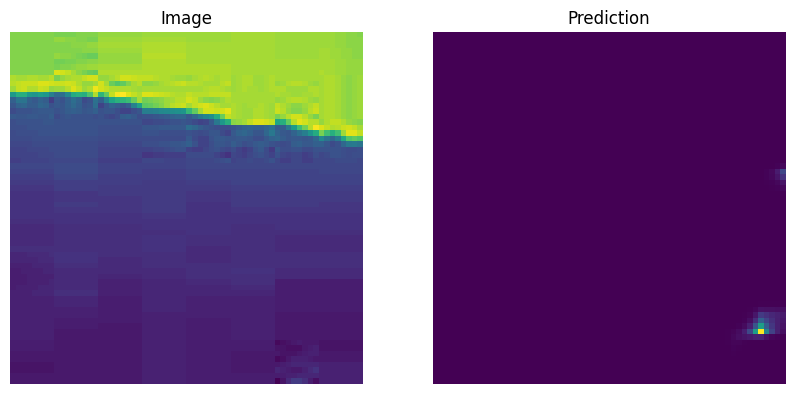

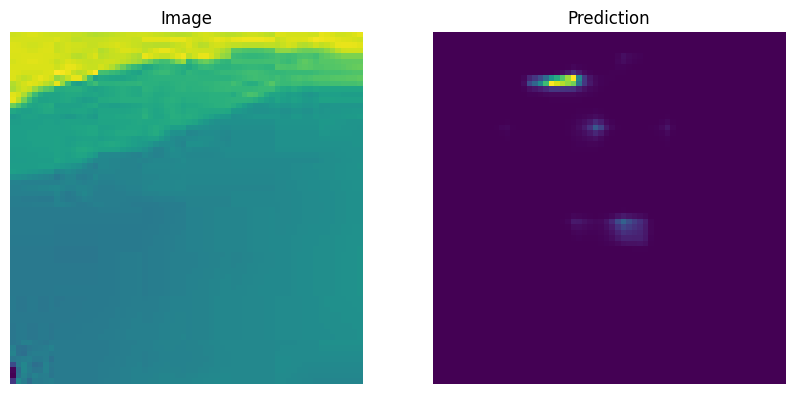

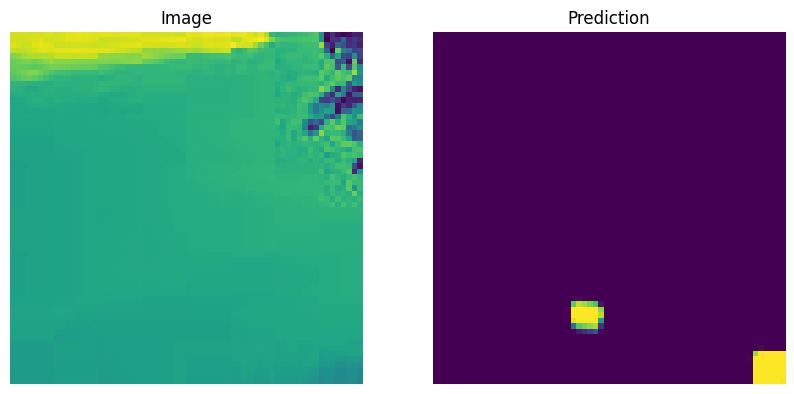

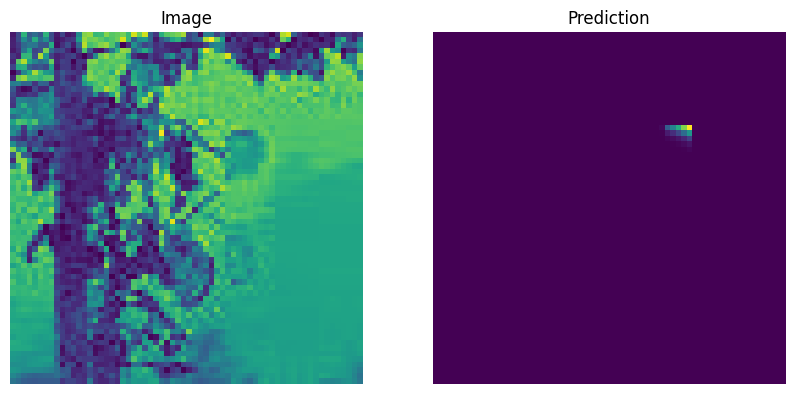

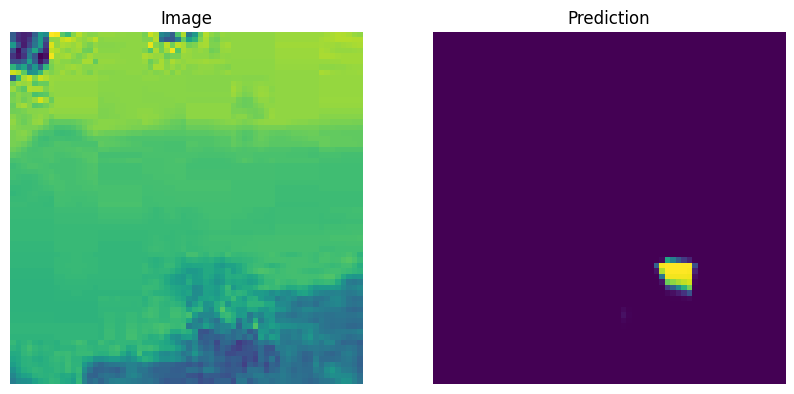

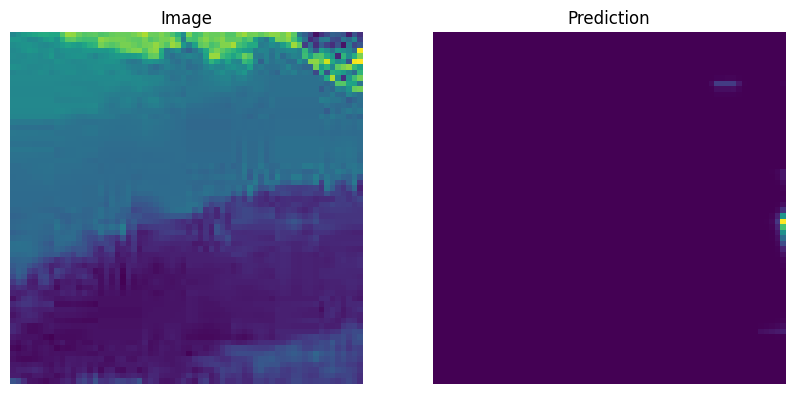

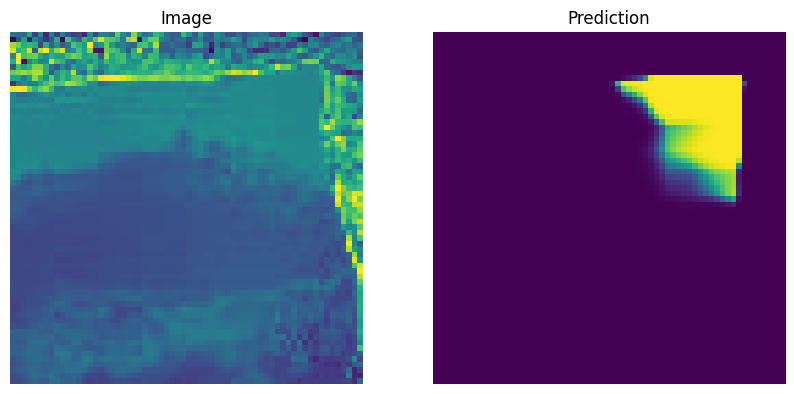

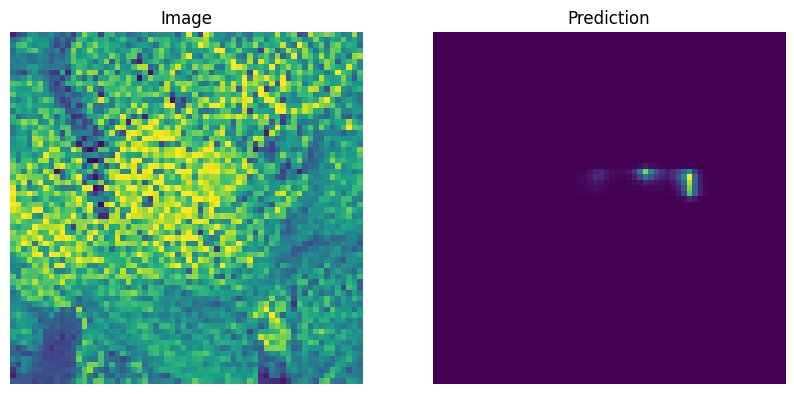

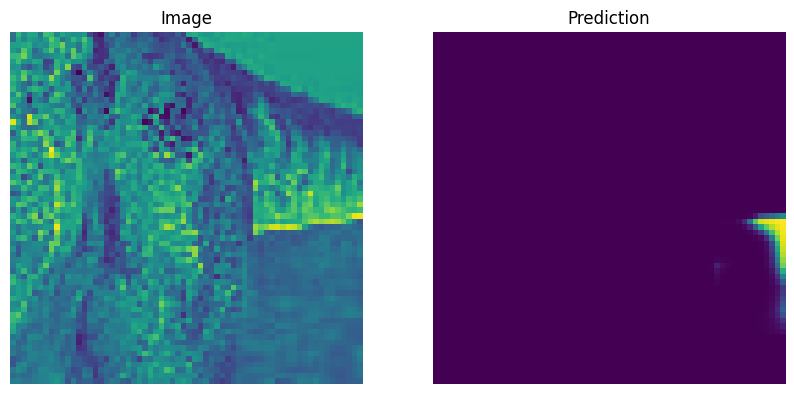

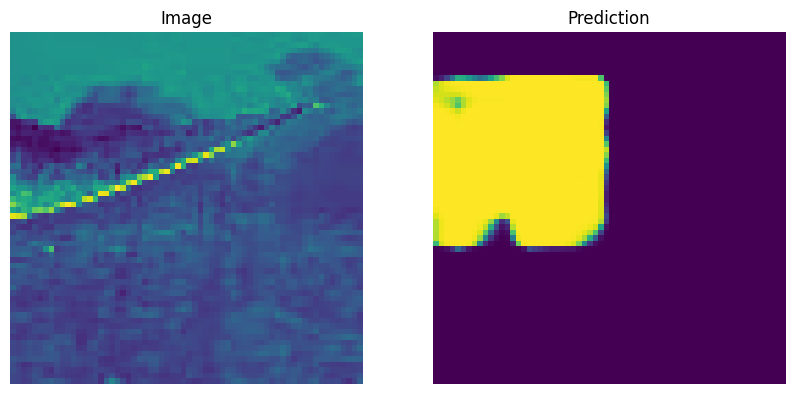

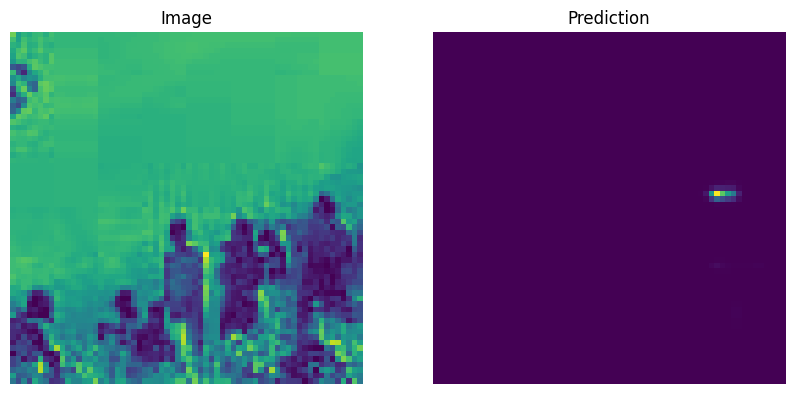

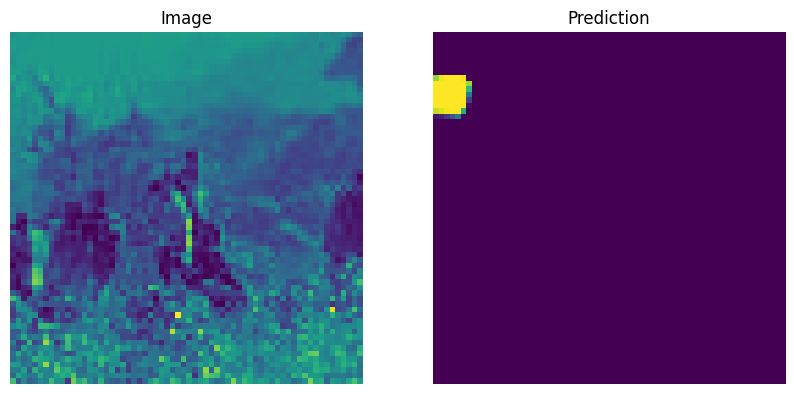

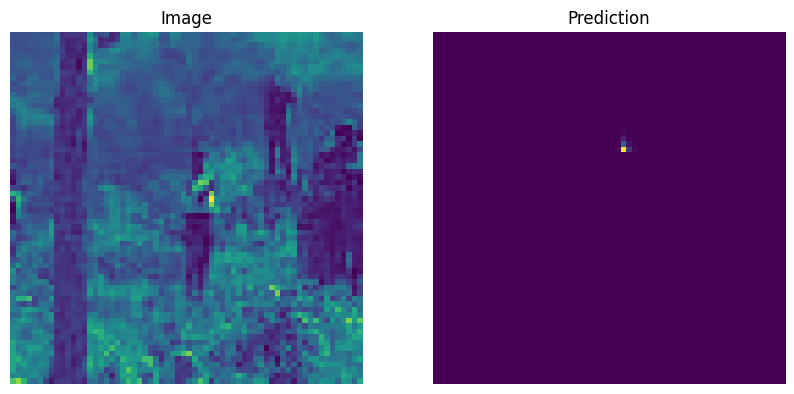

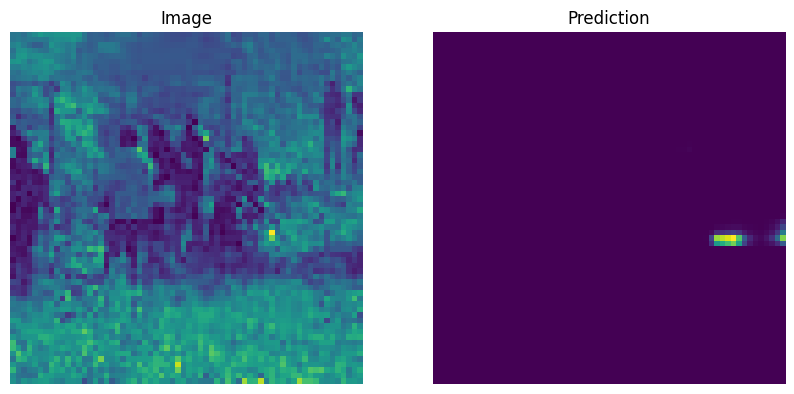

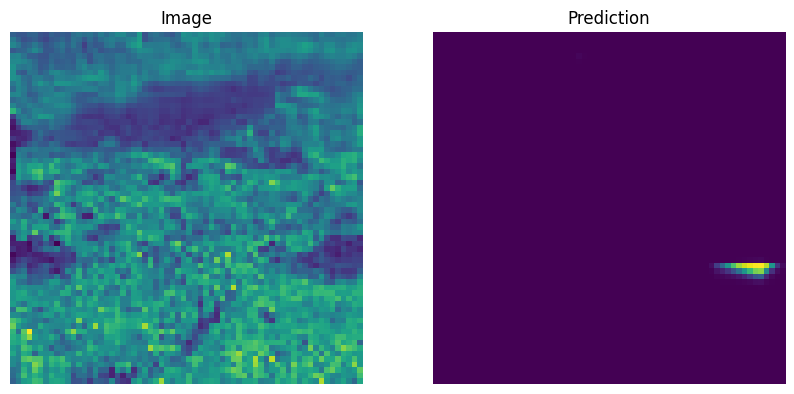

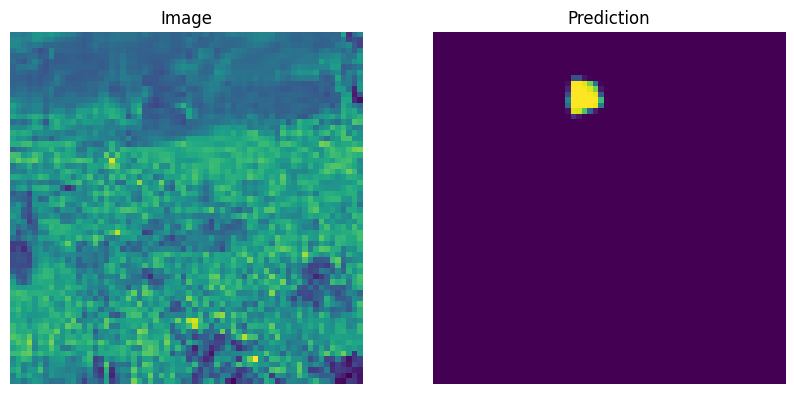

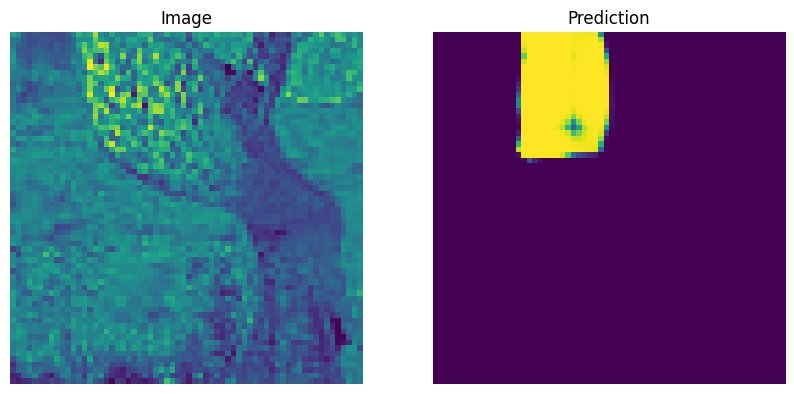

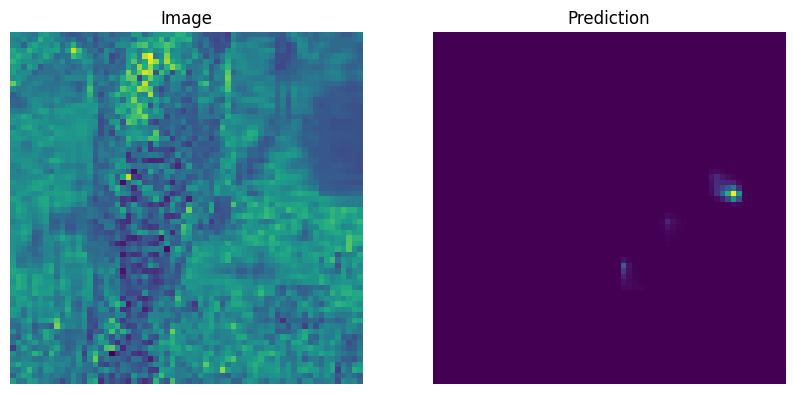

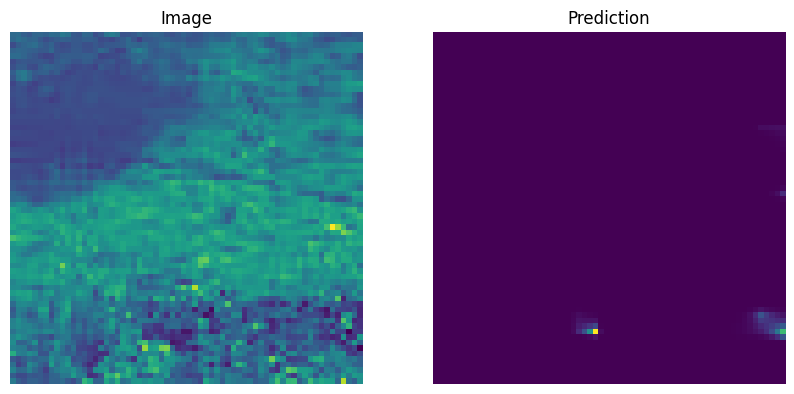

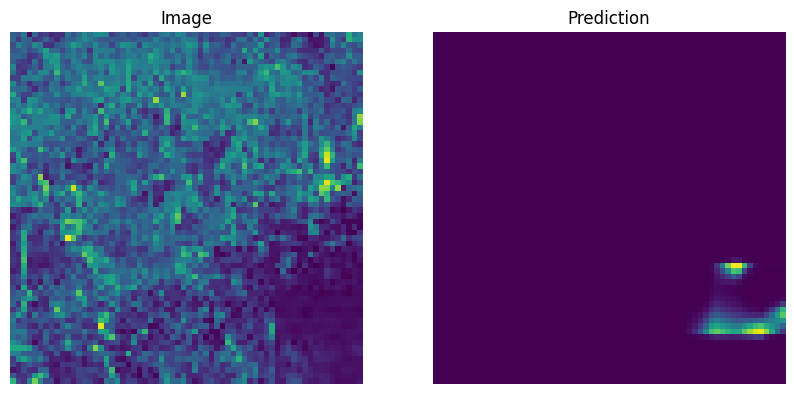

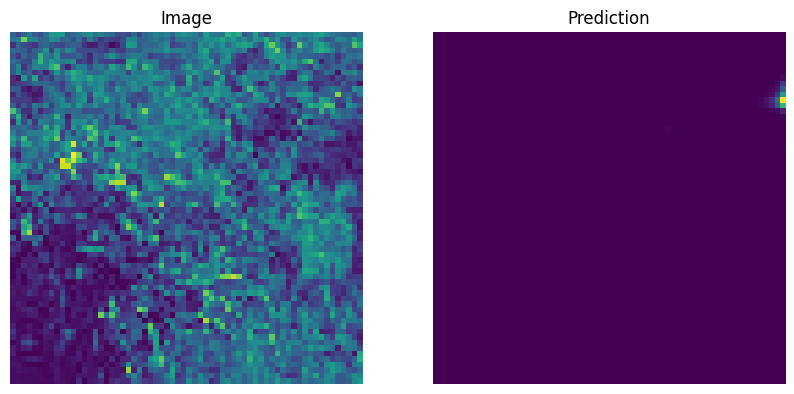

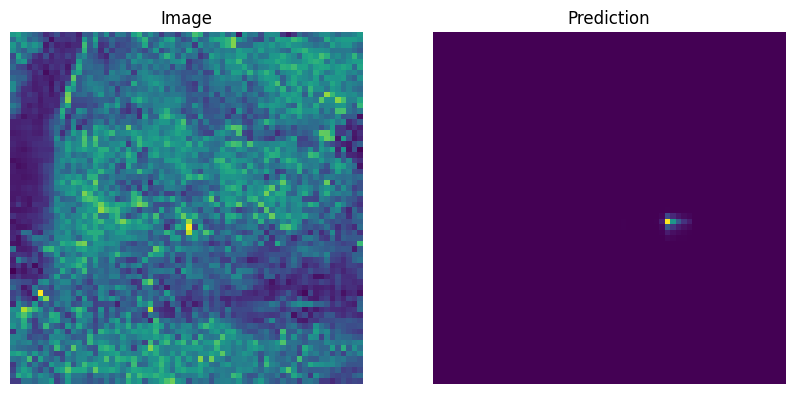

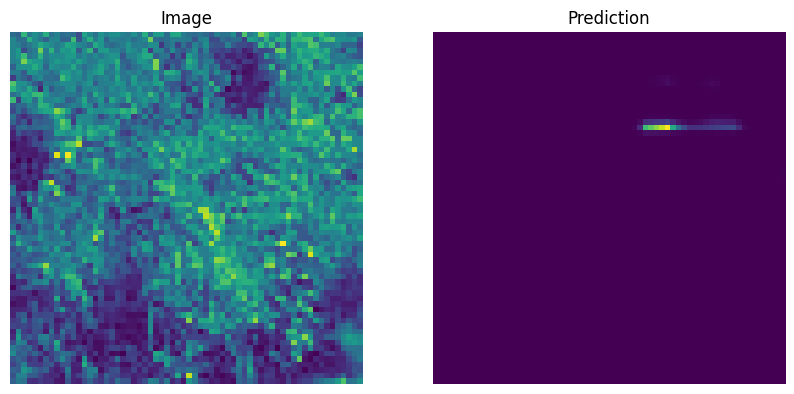

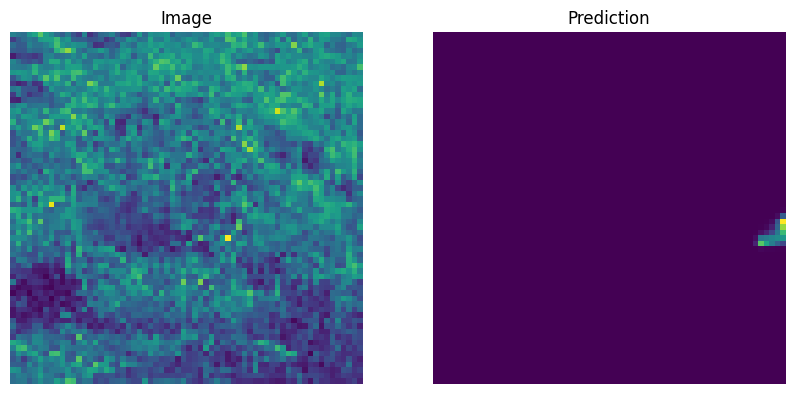

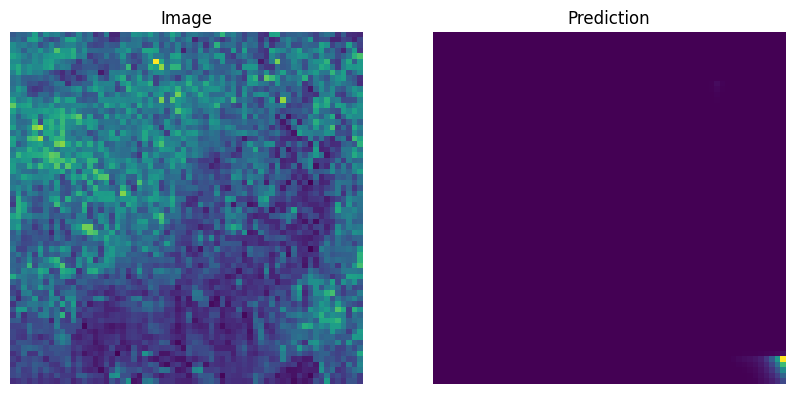

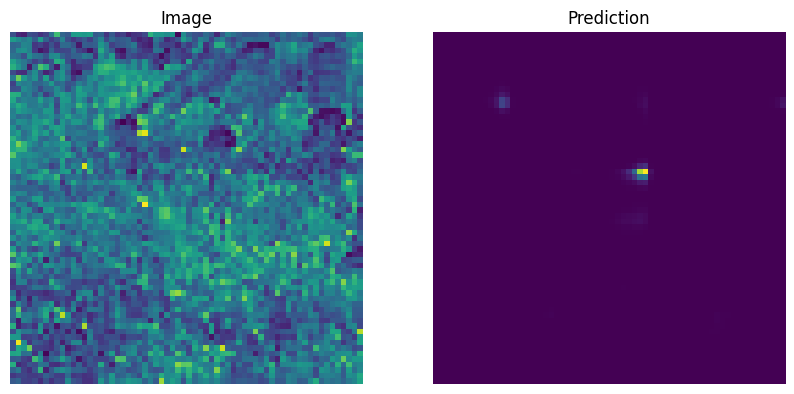

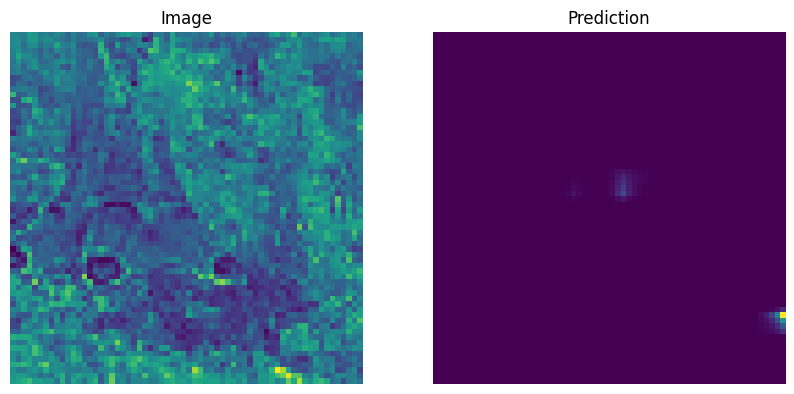

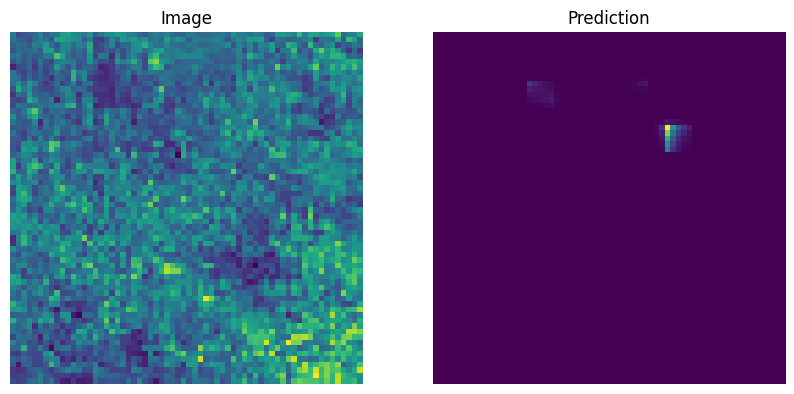

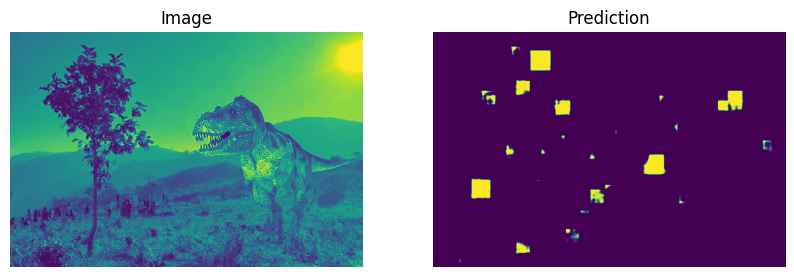

In [ ]:
for image in dataset:
    val_loader = torch.utils.data.DataLoader(image, batch_size=16, shuffle=False)
    batch = next(iter(val_loader))
    with torch.no_grad():
        model.eval()
        logits = model(image)
    pr_masks = logits.sigmoid()
    
    
    for image, pr_mask in zip(image, pr_masks):
        plt.figure(figsize=(10, 5))
    
        plt.subplot(1, 2, 1)
        plt.imshow(image)  # convert CHW -> HWC
        plt.title("Image")
        plt.axis("off")
    
        plt.subplot(1, 2, 2)
        plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
        plt.title("Prediction")
        plt.axis("off")
    
        plt.show()